In [1]:
from preprocessors.open_read_check import loader
from preprocessors.save_dataset import save_dataframe
from preprocessors.outliers_boxplot import outliers_box

from prep_tools.capper import cap_outliers
from prep_tools.scaler import scale_standard
from prep_tools.log_transform import log_transform
from prep_tools.check_skewness import check_skewness
from prep_tools.check_zeros import check_zeros
from prep_tools.power_transformer import power_transform
from prep_tools.quantile_transformer import quantile_transform
from prep_tools.log_plus import log_plus

from visualization.scaled_plotter import plot_scaled

## Preparing to ML
---

### Loading dataset after EDA

In [2]:
df = loader(dir_one="data", dir_two="processed", file_name="AirQualityUCI_missing_impt.csv")
df.head(5)

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
0,2004-03-10,18.00.00,2.6,1360.0,11.9,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18
1,2004-03-10,19.00.00,2.0,1292.0,9.4,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19
2,2004-03-10,20.00.00,2.2,1402.0,9.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20
3,2004-03-10,21.00.00,2.2,1376.0,9.2,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21
4,2004-03-10,22.00.00,1.6,1272.0,6.5,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22


### Let`s check outliers in whole dataset

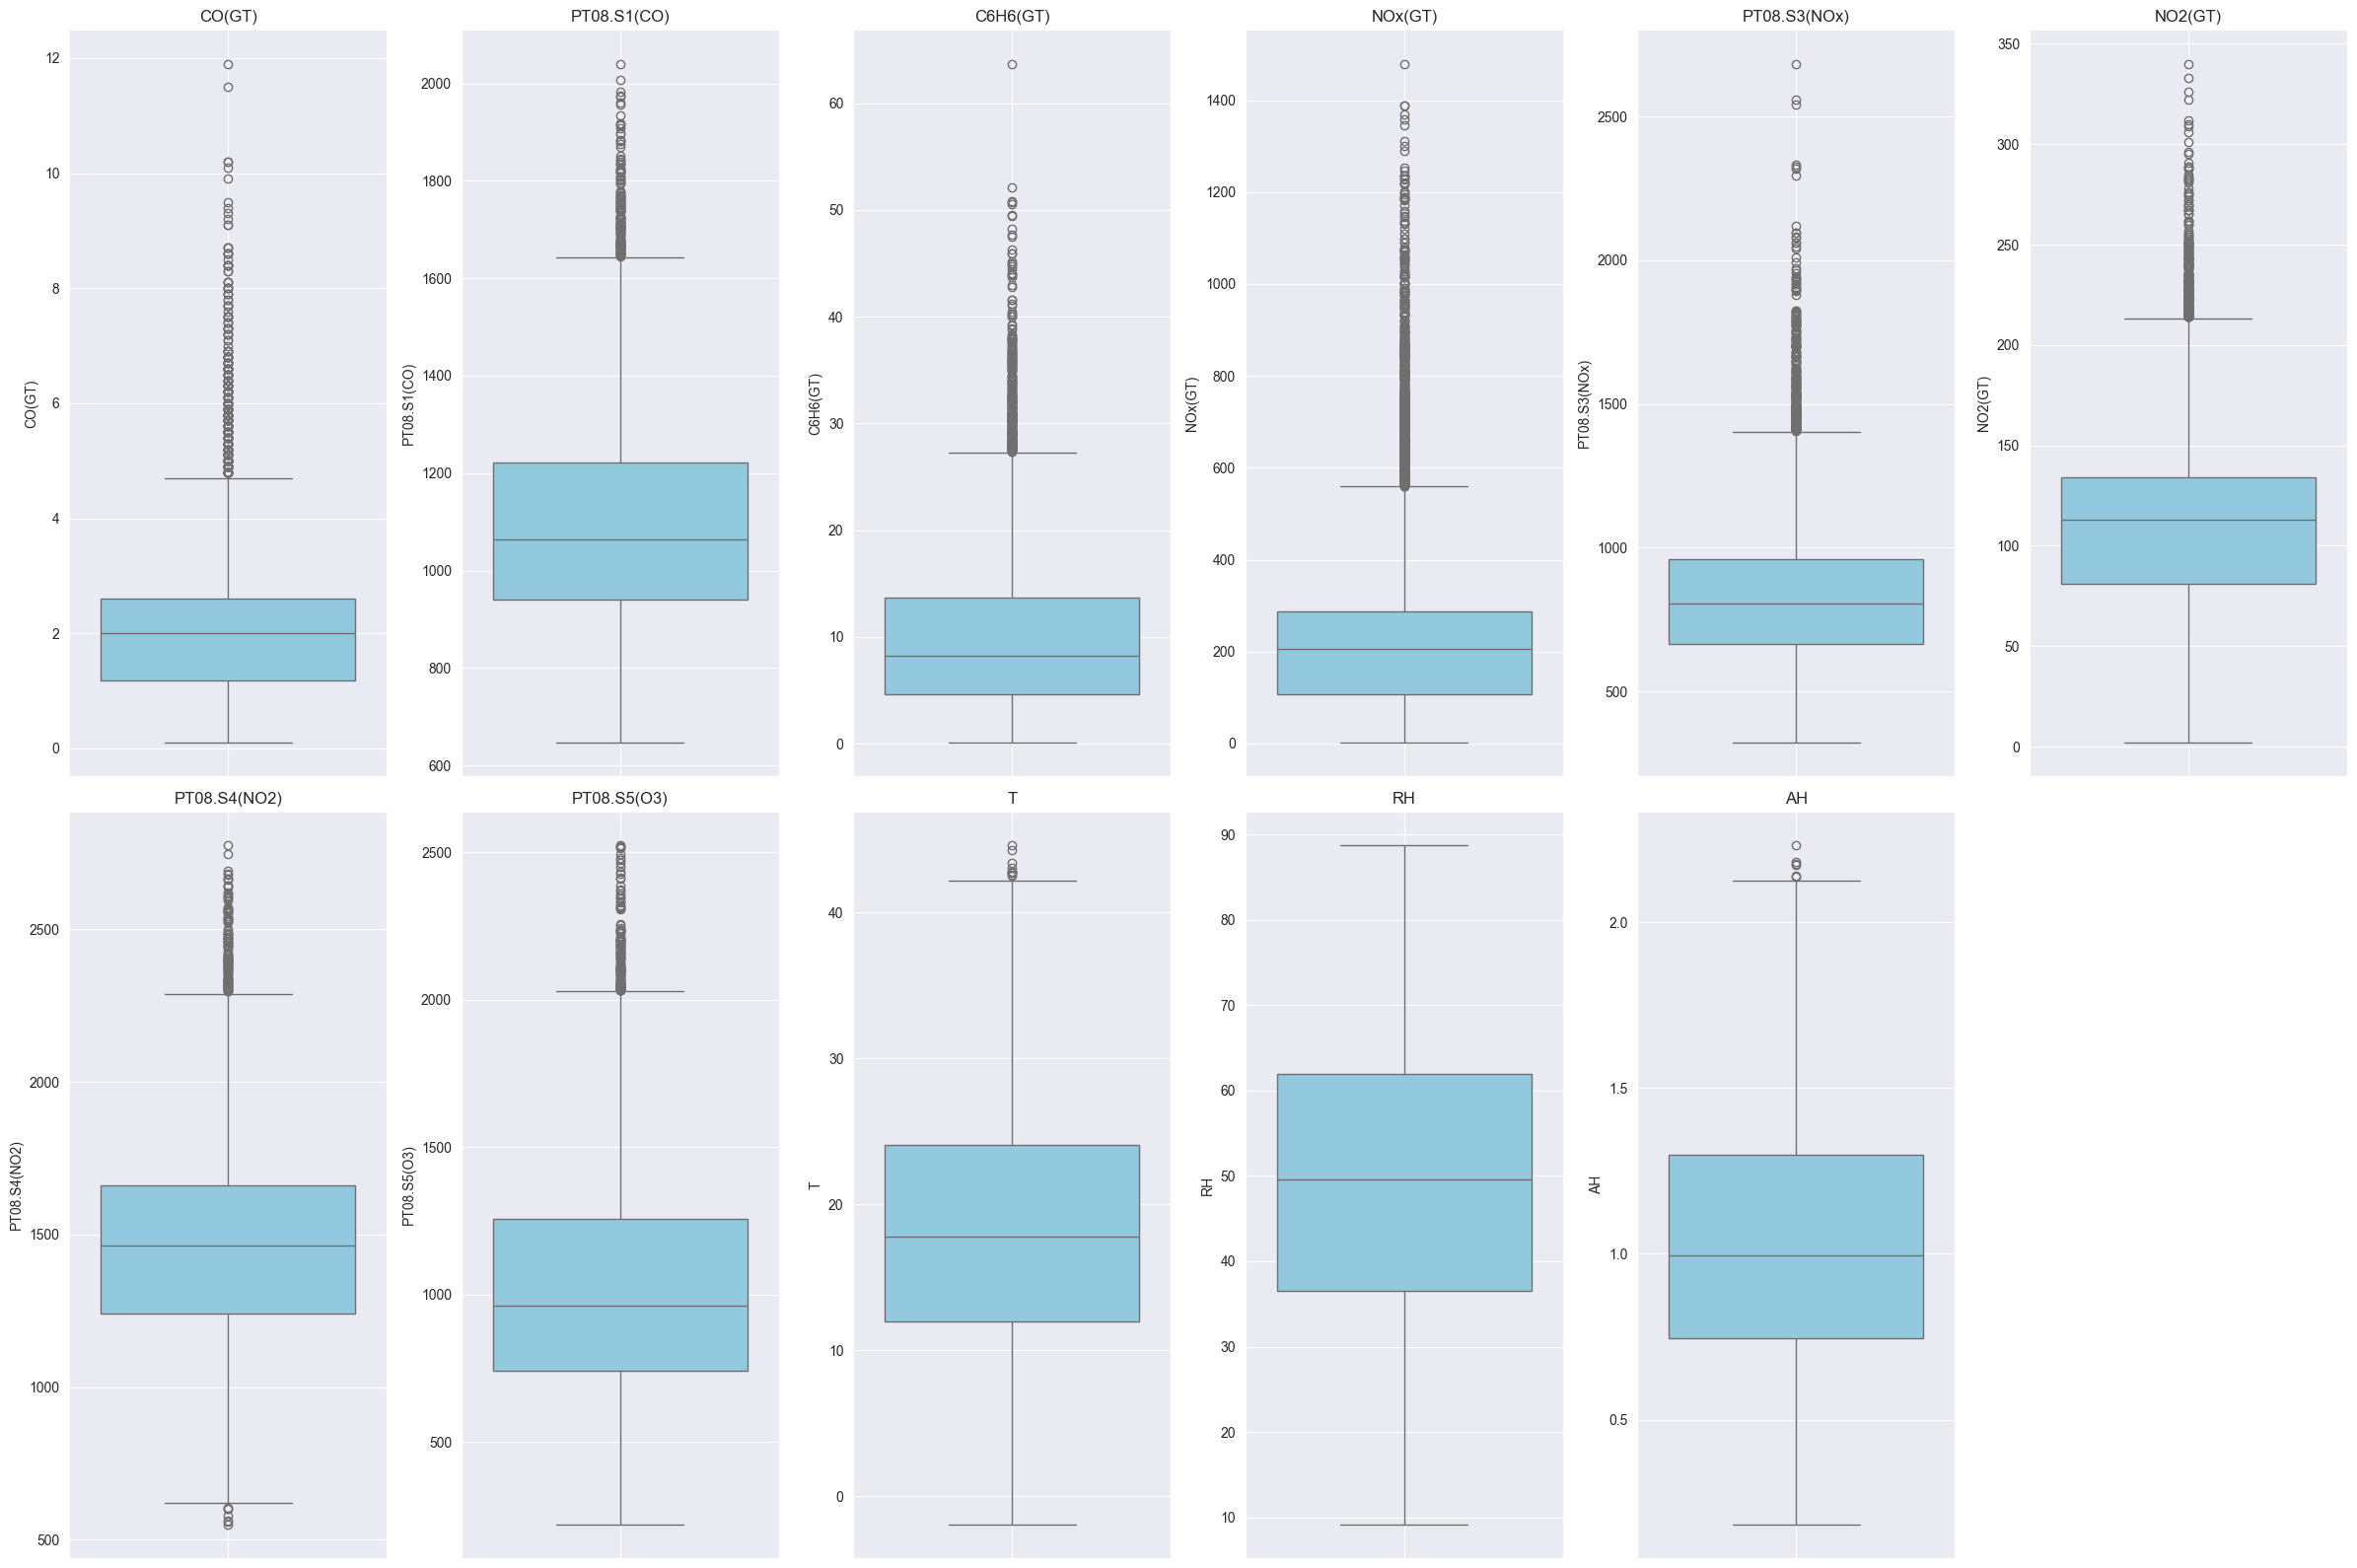

In [3]:
outliers_box(df)

# Preparation according EDA results

## Capper
---

### Goal of Applying the Capper

The goal of implementing the capper was to reduce the impact of extreme outliers in the numerical features of the dataset. Outliers can distort statistical summaries, affect the performance of machine learning models, and lead to overfitting or unstable predictions.

By capping the values beyond the specified quantile thresholds, we aimed to:

- Reduce the influence of anomalous sensor readings or rare events.
- Preserve the natural distribution of each feature while controlling for noise.
- Prepare the data for scaling and modeling by ensuring numerical stability.

This preprocessing step enhances the reliability of downstream machine learning tasks by promoting a more balanced and robust feature set.


### Let`s choose columns for capper realisation

In [4]:
cap_cols = [
    'C6H6(GT)',     # target має викиди (до 60+)
    'CO(GT)',       # часті й високі сплески
    'NOx(GT)',      # дуже довгий хвіст
    'NO2(GT)',      # значна асиметрія
    'PT08.S1(CO)', 'PT08.S3(NOx)',
    'PT08.S4(NO2)', 'PT08.S5(O3)'  # сенсори мають широкі діапазони та багато аномалій
]

### Run capper

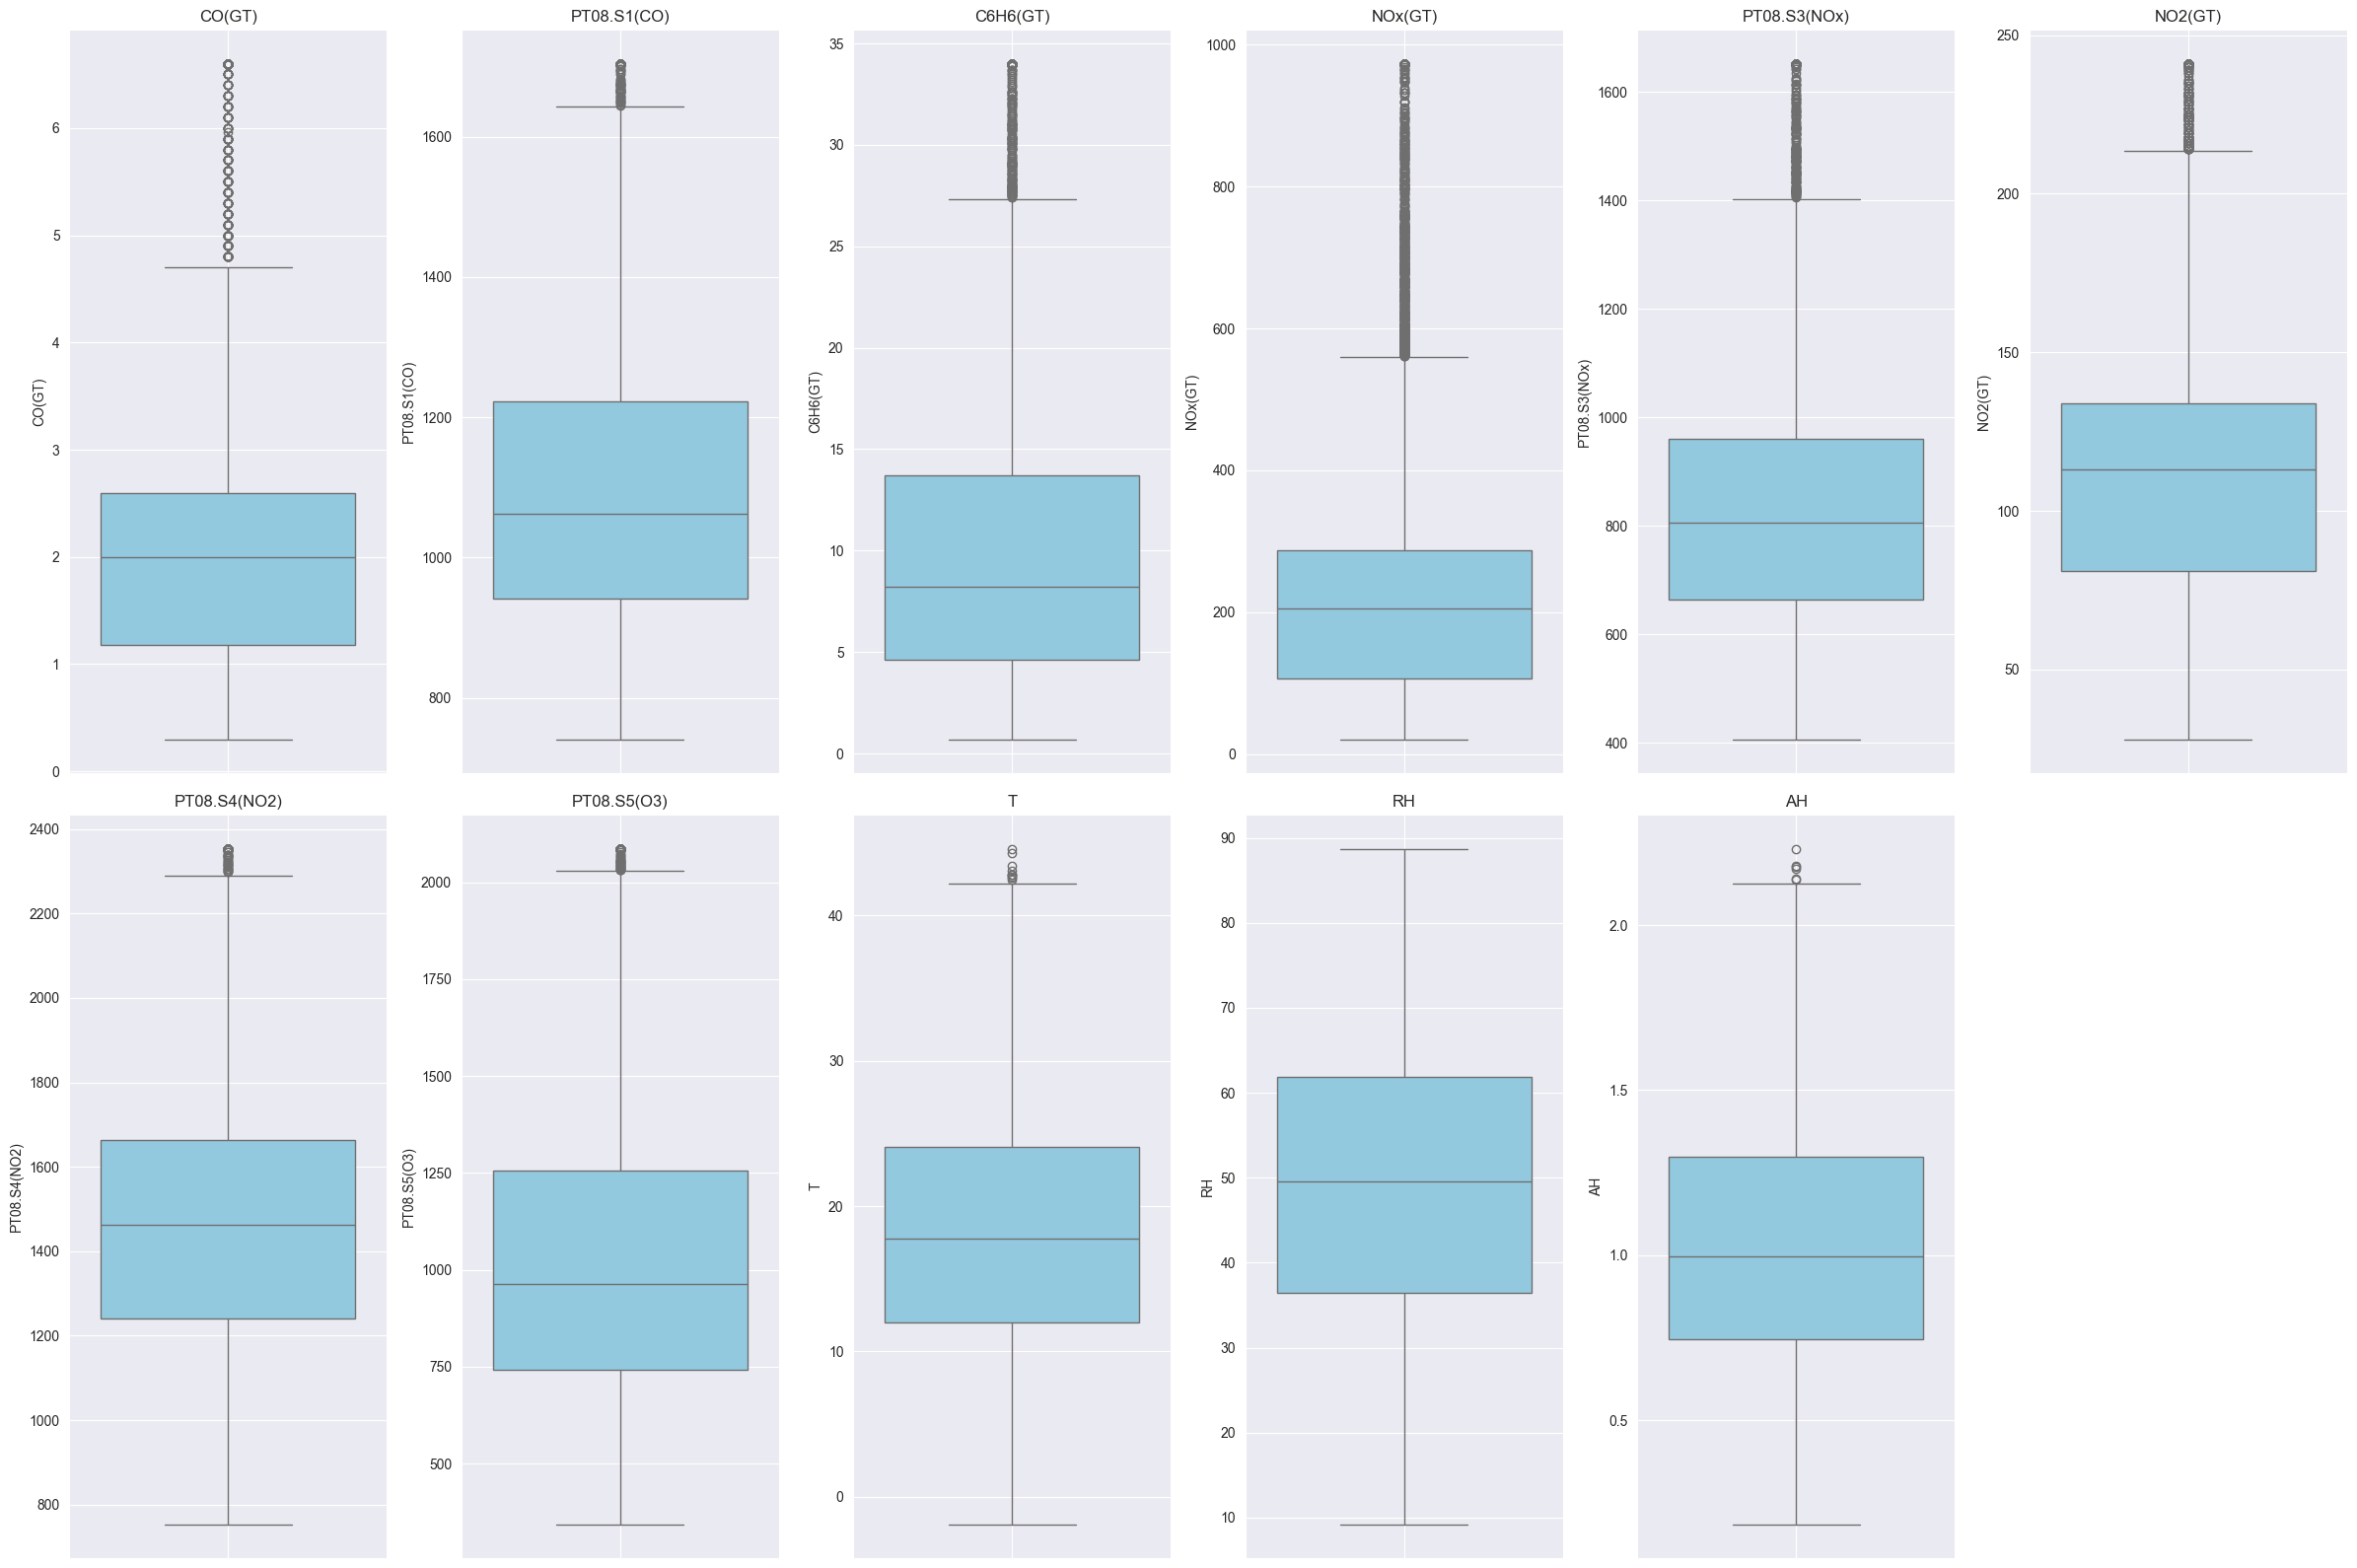

In [5]:
df_cap = cap_outliers(df, cap_cols)
outliers_box(df_cap)

### Analysis After Applying the Capper

After applying the outlier capping procedure, the updated boxplots show a significant improvement in data distribution across the key numerical features. Here's a concise analysis of the impact:

The previously extreme outliers have been successfully capped in most columns, resulting in tighter interquartile ranges and more compact whiskers. This enhances the robustness of the dataset by reducing the influence of extreme values that could skew machine learning models.

Notably, variables such as `CO(GT)`, `C6H6(GT)`, and `NOx(GT)` show visibly reduced upper outliers while preserving the general shape and variability of their distributions. Sensor-based measurements like `PT08.S1(CO)` and `PT08.S3(NOx)` still retain some mild outlier presence, which is acceptable due to their nature and sensitivity.

The transformation maintains interpretability and integrity of the data while reducing noise. Overall, the capper improved the dataset's consistency, making it more suitable for scaling and machine learning model training.


# Scaler
---

### Goal of Applying the Standard Scaler

The purpose of applying standard scaling is to normalize the range and distribution of numerical features by centering them around a mean of 0 and a standard deviation of 1.

Machine learning algorithms that rely on distance calculations or regularization—such as linear regression, support vector machines, and gradient descent–based models—perform better when features are on a similar scale.

By standardizing the data, we aim to:

- Ensure all numerical features contribute equally to model learning.
- Improve the stability and convergence speed of optimization algorithms.
- Prevent features with large magnitudes from dominating model behavior.

This transformation is essential for preparing the dataset for a wide range of machine learning techniques.


### Let`s choose columns for scaler realisation

In [6]:
scale_cols = cap_cols + ['T', 'RH', 'AH']

### Run scaler

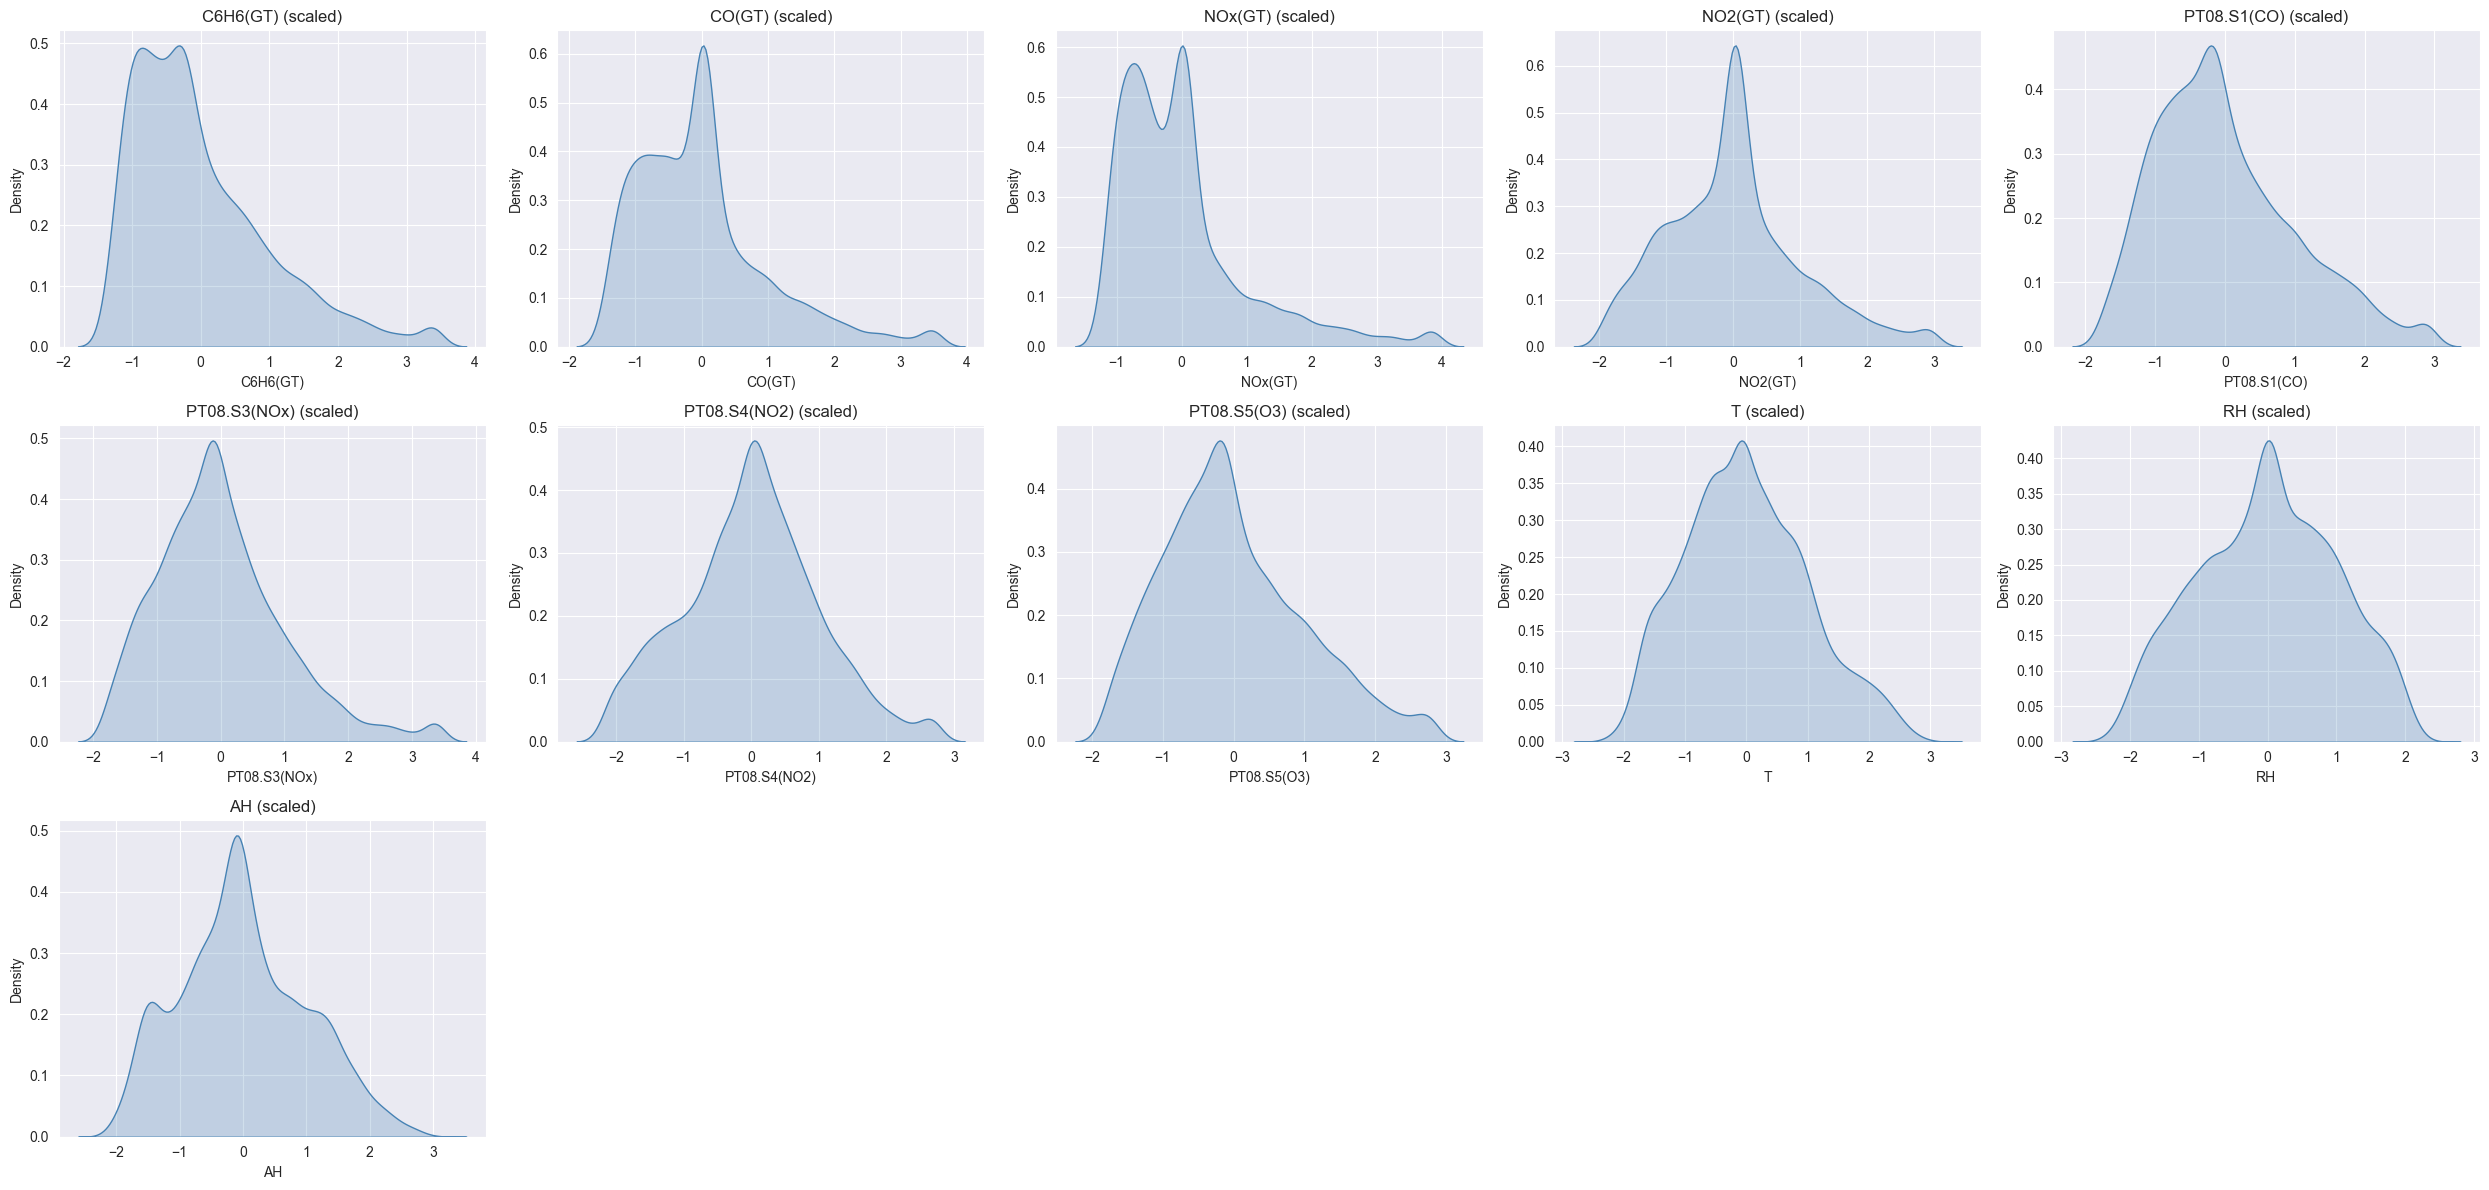

In [7]:
df_scl = scale_standard(df_cap, scale_cols)
plot_scaled(df_scl, scale_cols)


### Analysis of Scaling Results

After applying the StandardScaler, all feature distributions have been rescaled to have a mean of approximately 0 and a standard deviation of 1. This standardization ensures that each feature contributes equally to distance-based models and gradient-based optimization.

Despite the successful scaling, many distributions (e.g., NOx(GT), CO(GT), C6H6(GT)) still exhibit strong skewness and heavy tails. This suggests that standard scaling alone does not address distributional asymmetry.

# Skewness checker
---

### Skewness Checker Preview

This function calculates the skewness (a dimensionless measure of asymmetry) for all numeric features in the dataset. A value of `0` indicates a perfectly symmetric (normal) distribution, while positive values indicate right-skewed distributions and negative values indicate left-skewed ones.

The output includes a `Skewness` value and a `Skewed` flag. The `Skewed` column returns `True` if the absolute skewness exceeds a defined threshold (default is 0.5), indicating that the feature may benefit from transformation (e.g., log or power transform) prior to modeling.


In [8]:
check_skewness(df_scl)

,Skewness,Skewed
NOx(GT),1.635946,True
CO(GT),1.175142,True
C6H6(GT),1.158963,True
PT08.S3(NOx),0.826261,True
PT08.S1(CO),0.704998,True
PT08.S5(O3),0.591406,True
NO2(GT),0.546539,True
T,0.321384,False
AH,0.264082,False
PT08.S4(NO2),0.136388,False


### Skewness Analysis Report

The skewness results reveal that most of the features remain significantly right-skewed, even after scaling. Below is a grouped interpretation:

#### Highly skewed features (skewness > 1.0)
- `NOx(GT)` (1.63), `CO(GT)` (1.17), `C6H6(GT)` (1.16)
→ These variables show strong right-skewness, which suggests the presence of a long tail on the higher end. This can negatively affect linear models and distance-based algorithms. **Log-transform or power-transform is recommended.**

#### Moderately skewed features (0.5 < skewness ≤ 1.0)
- `PT08.S3(NOx)`, `PT08.S1(CO)`, `PT08.S5(O3)`, `NO2(GT)`
→ These are still skewed enough to consider transformation, though not as extreme. Transforming them could slightly improve model interpretability and performance.

#### Approximately symmetric features (|skewness| < 0.5)
- `T`, `AH`, `PT08.S4(NO2)`
→ These variables are nearly symmetric and **do not require transformation**. Their distribution is relatively balanced and already in a good shape for modeling.

### Conclusion

- **Actionable**: We should transform the features marked as `True` under `Skewed`, especially those with high skewness values.
- **Next Step**: Apply log-transform or another suitable normalization technique to reduce skewness and enhance model performance.

# Transformation to avoid skewness
---

## Feature Transformation Description

In this section, we are testing different transformation techniques to avoid the skewness of several highly skewed features in our dataset. The purpose was to improve feature distribution to better match assumptions of many machine learning algorithms, particularly linear models and those sensitive to feature scale or distribution.

### Sorts Transformations

1. **Quantile Transformer**
   - Transforms the features to follow a normal (Gaussian) distribution using quantile mapping.
   - Results in symmetric, bell-shaped distributions.
   - Can distort the feature relationships due to aggressive reshaping.
<br>
<br>
2. **Power Transformer (Yeo-Johnson)**
   - A flexible transformation method that handles both positive and negative values.
   - Aims to make data more Gaussian-like while preserving original feature order.
   - Typically preserves feature structure better than Quantile.
<br>
<br>
3. **Log Transformation**
   - Applied with a positive shift to avoid undefined values on non-positive numbers.
   - We added a bias to values to avoid dealing with negative values that were added after scaling.
   - Simple and interpretable.
   - Reduces right skewness effectively but compresses range heavily.
<br>
<br>
4. **Log Transform + Standard Scaling**
   - Adds a normalization step post-log-transform.
   - Ensures the final features are standardized (mean 0, std 1).
   - Useful when models are sensitive to scale, like gradient descent-based ones.

### Let`s choose columns for transformation, based on skewness-checker results

In [9]:
tran_cols = [
    'C6H6(GT)',
    'CO(GT)',
    'NOx(GT)',
    'NO2(GT)',
    'PT08.S1(CO)', 'PT08.S3(NOx)', 'PT08.S5(O3)'
]

### Let`s check different types of transformation

- Quantile transformer

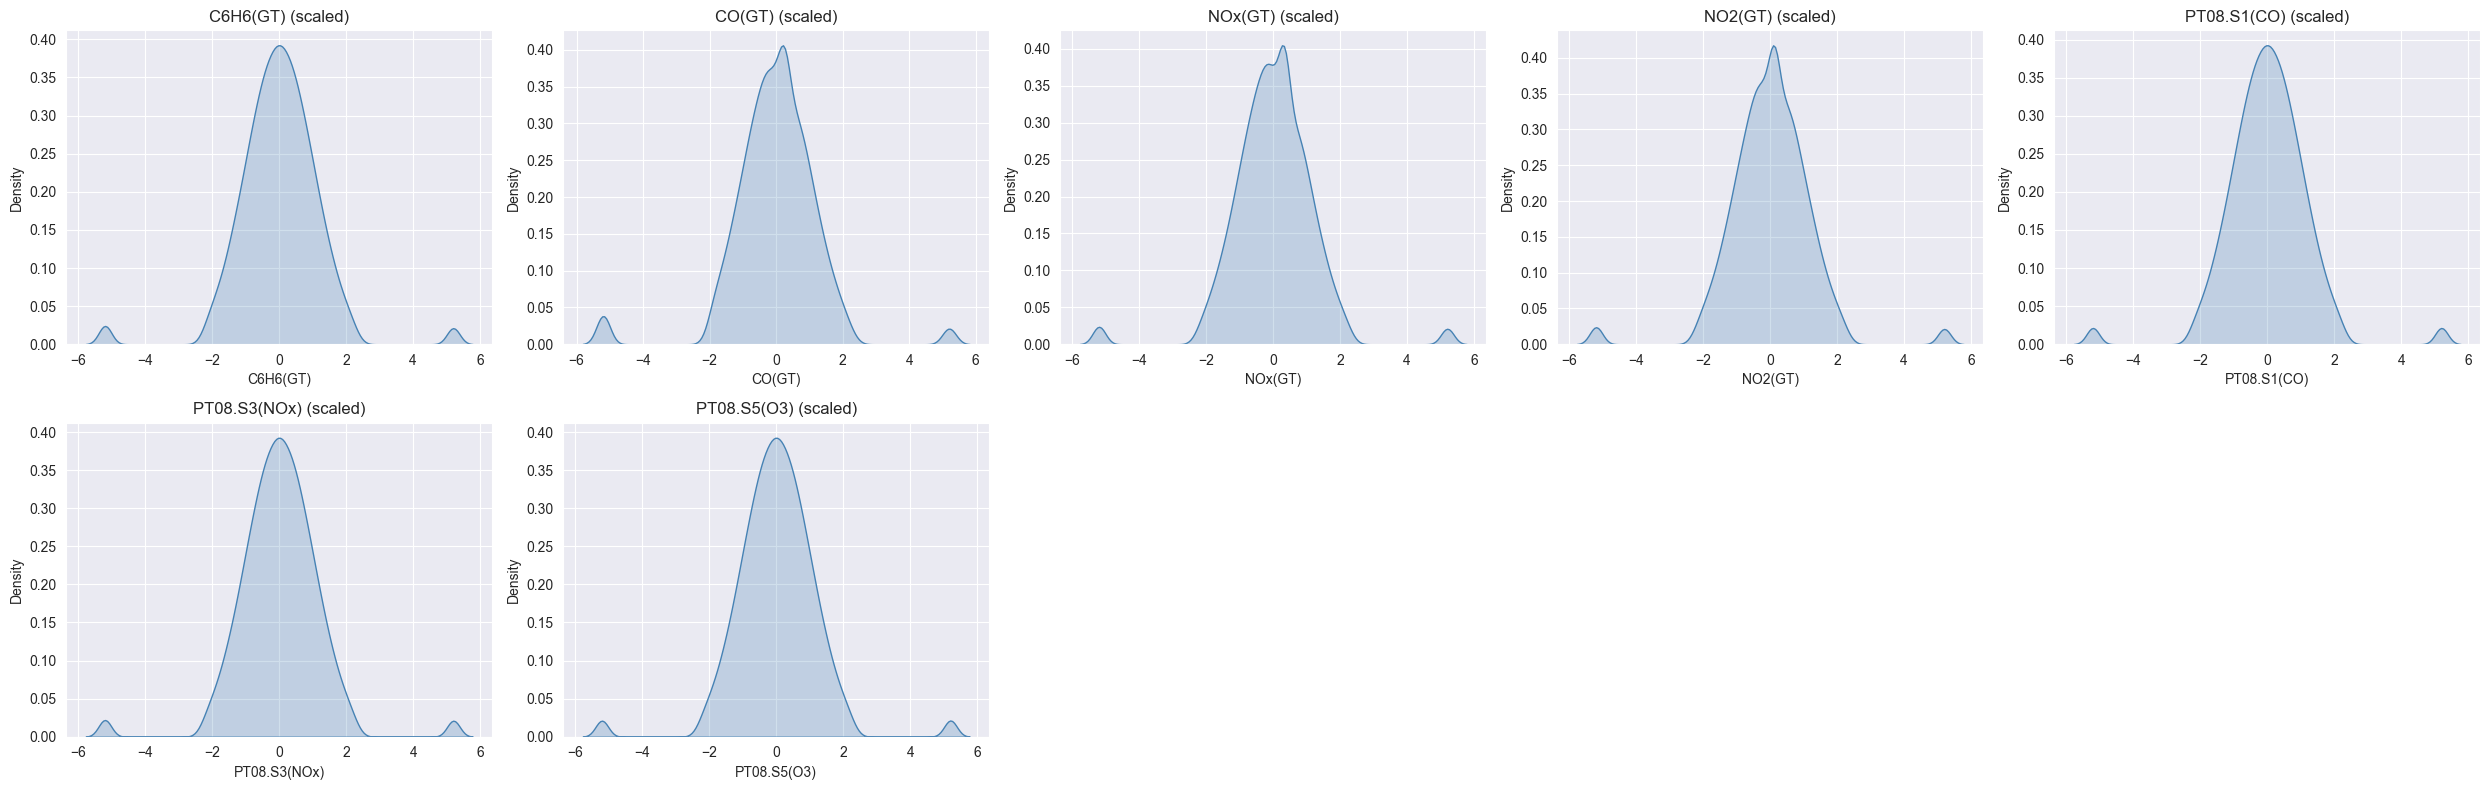

In [10]:
df_quant = quantile_transform(df_scl, tran_cols)
plot_scaled(df_quant, tran_cols)

- Power tharnsformer (yeo-johnson)

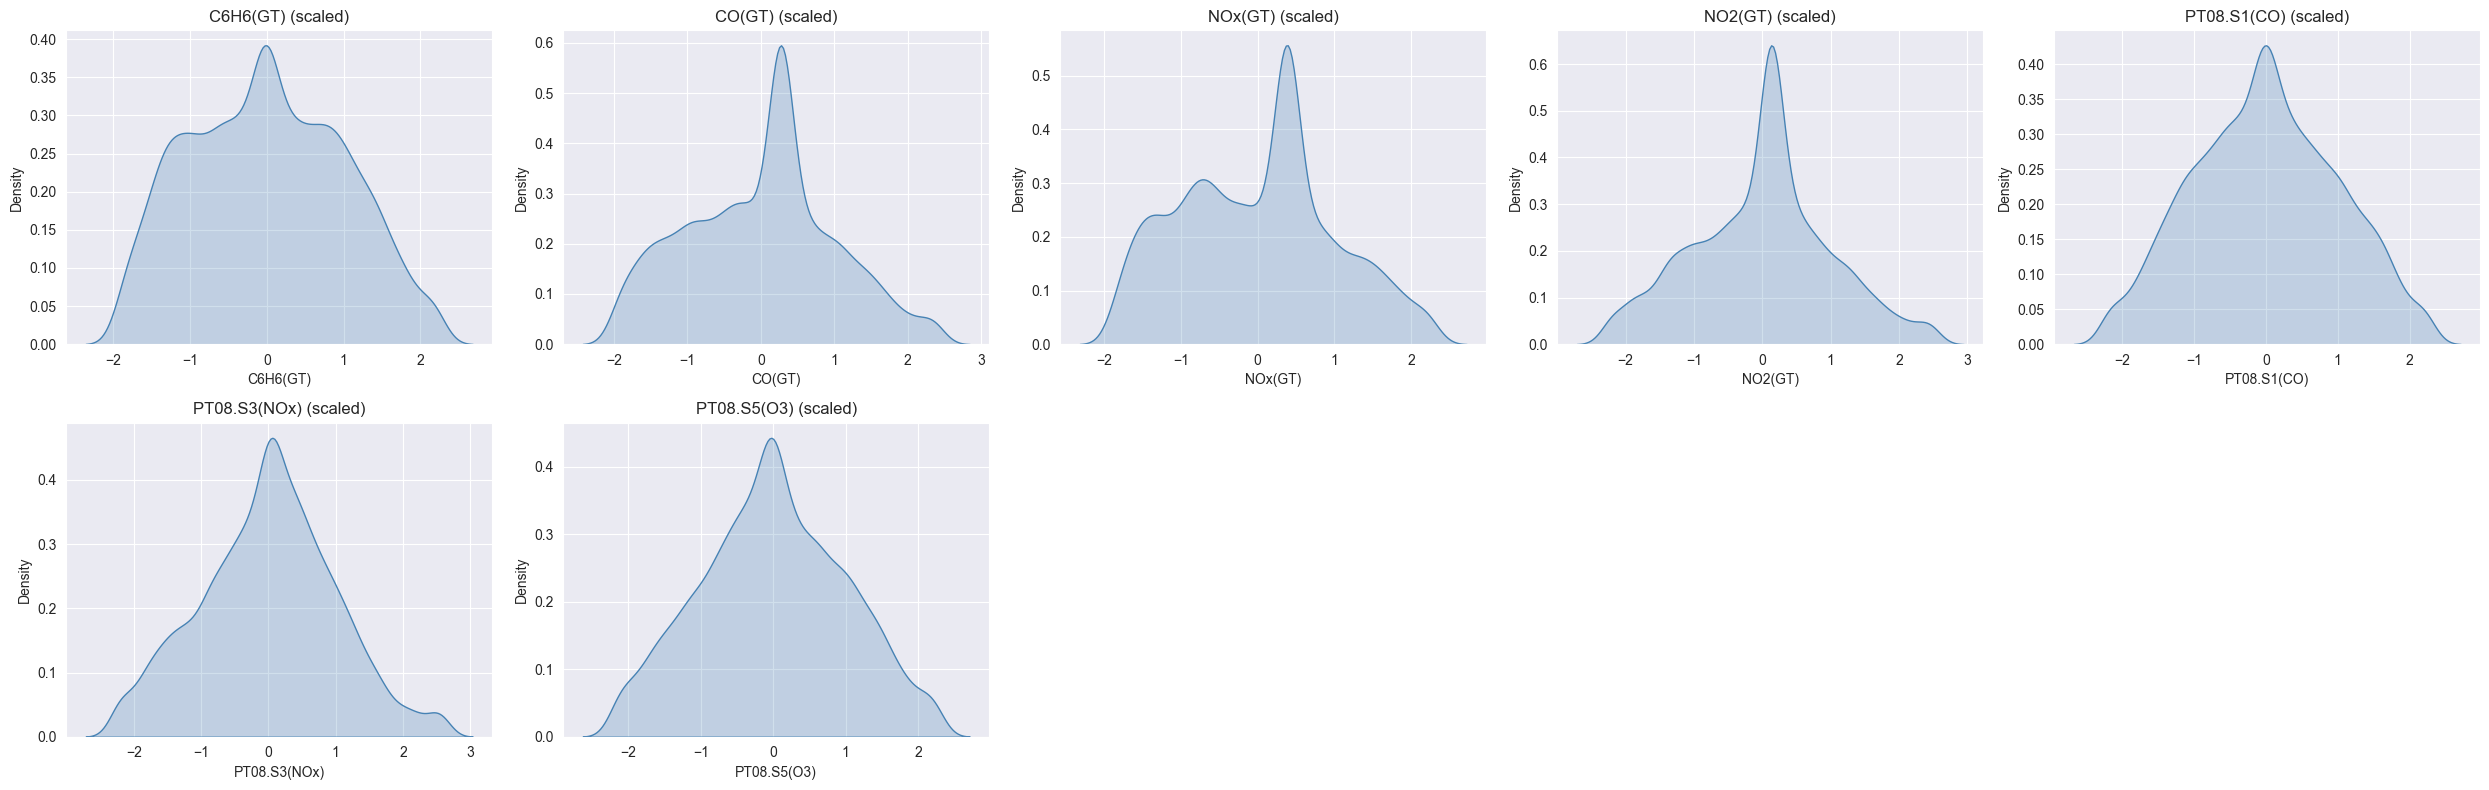

In [11]:
df_pow = power_transform(df_scl, tran_cols)
plot_scaled(df_pow, tran_cols)

- Log transformer

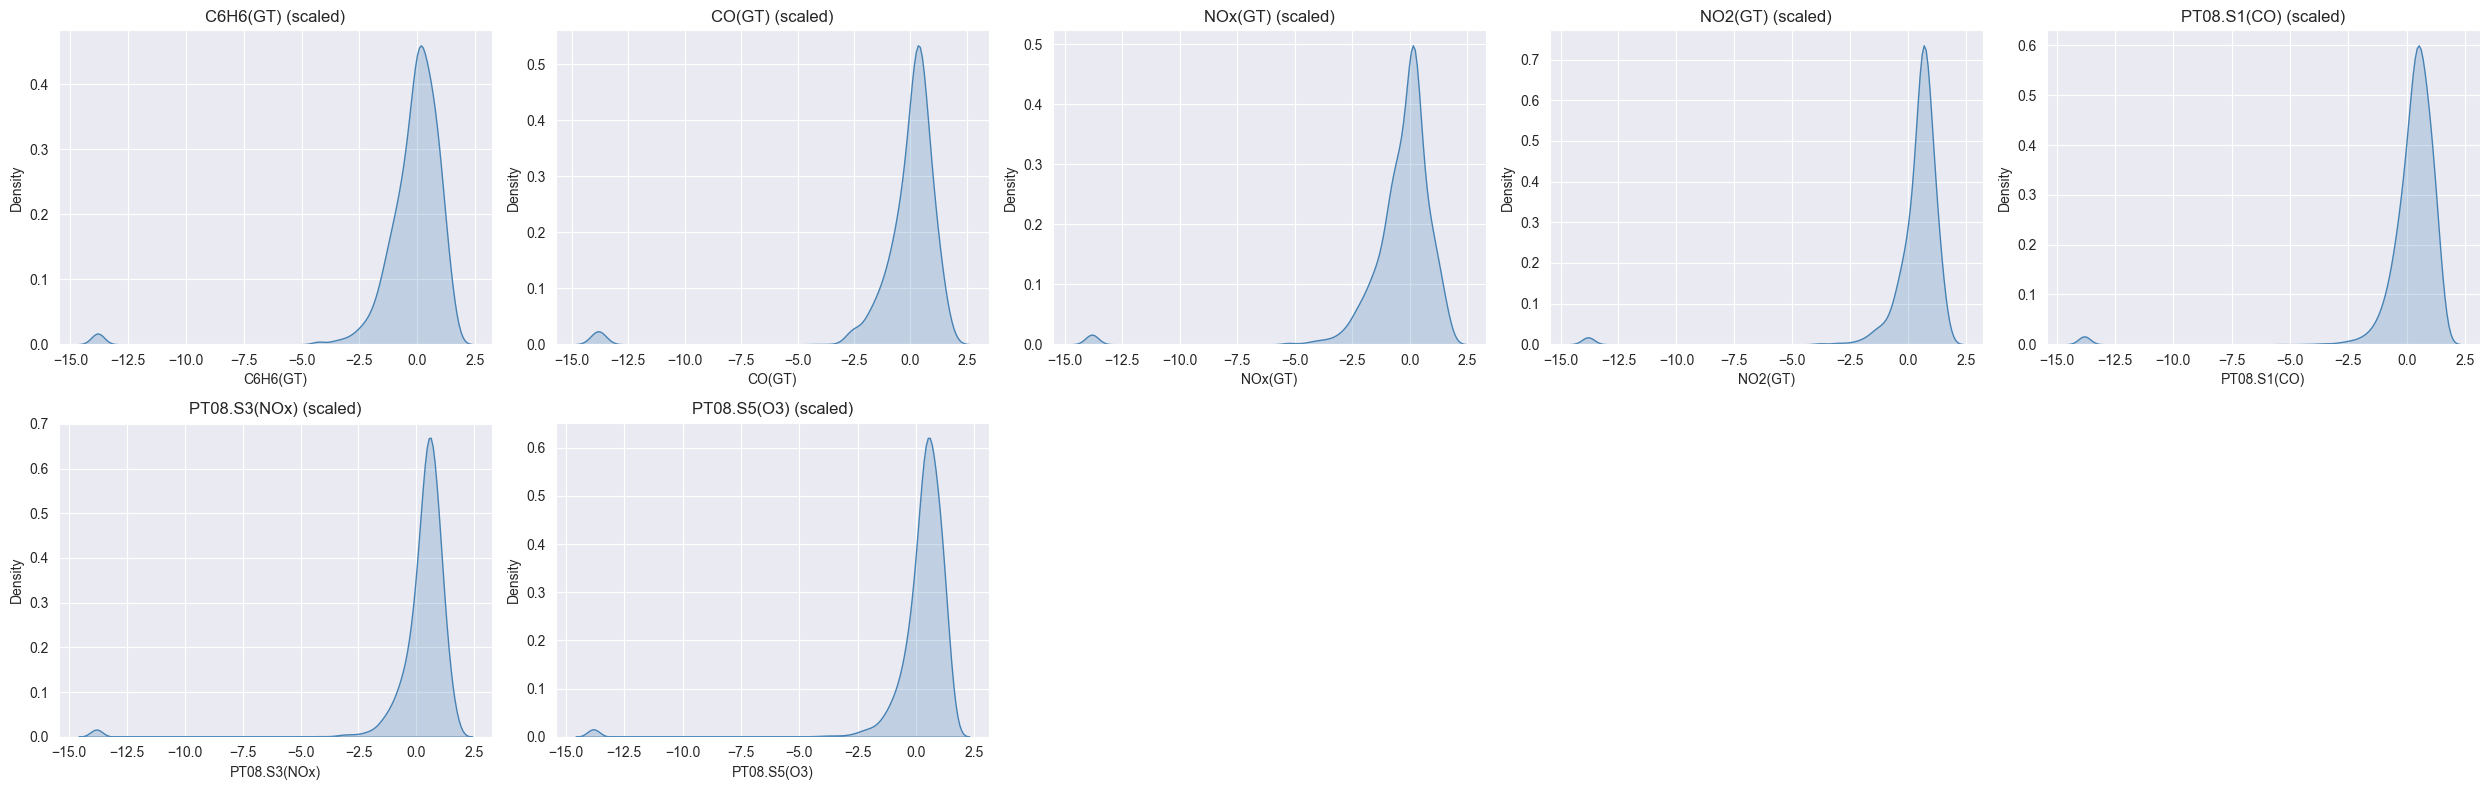

In [12]:
df_log = log_plus(df_scl, tran_cols)
plot_scaled(df_log, tran_cols)

- Log transform after scaling

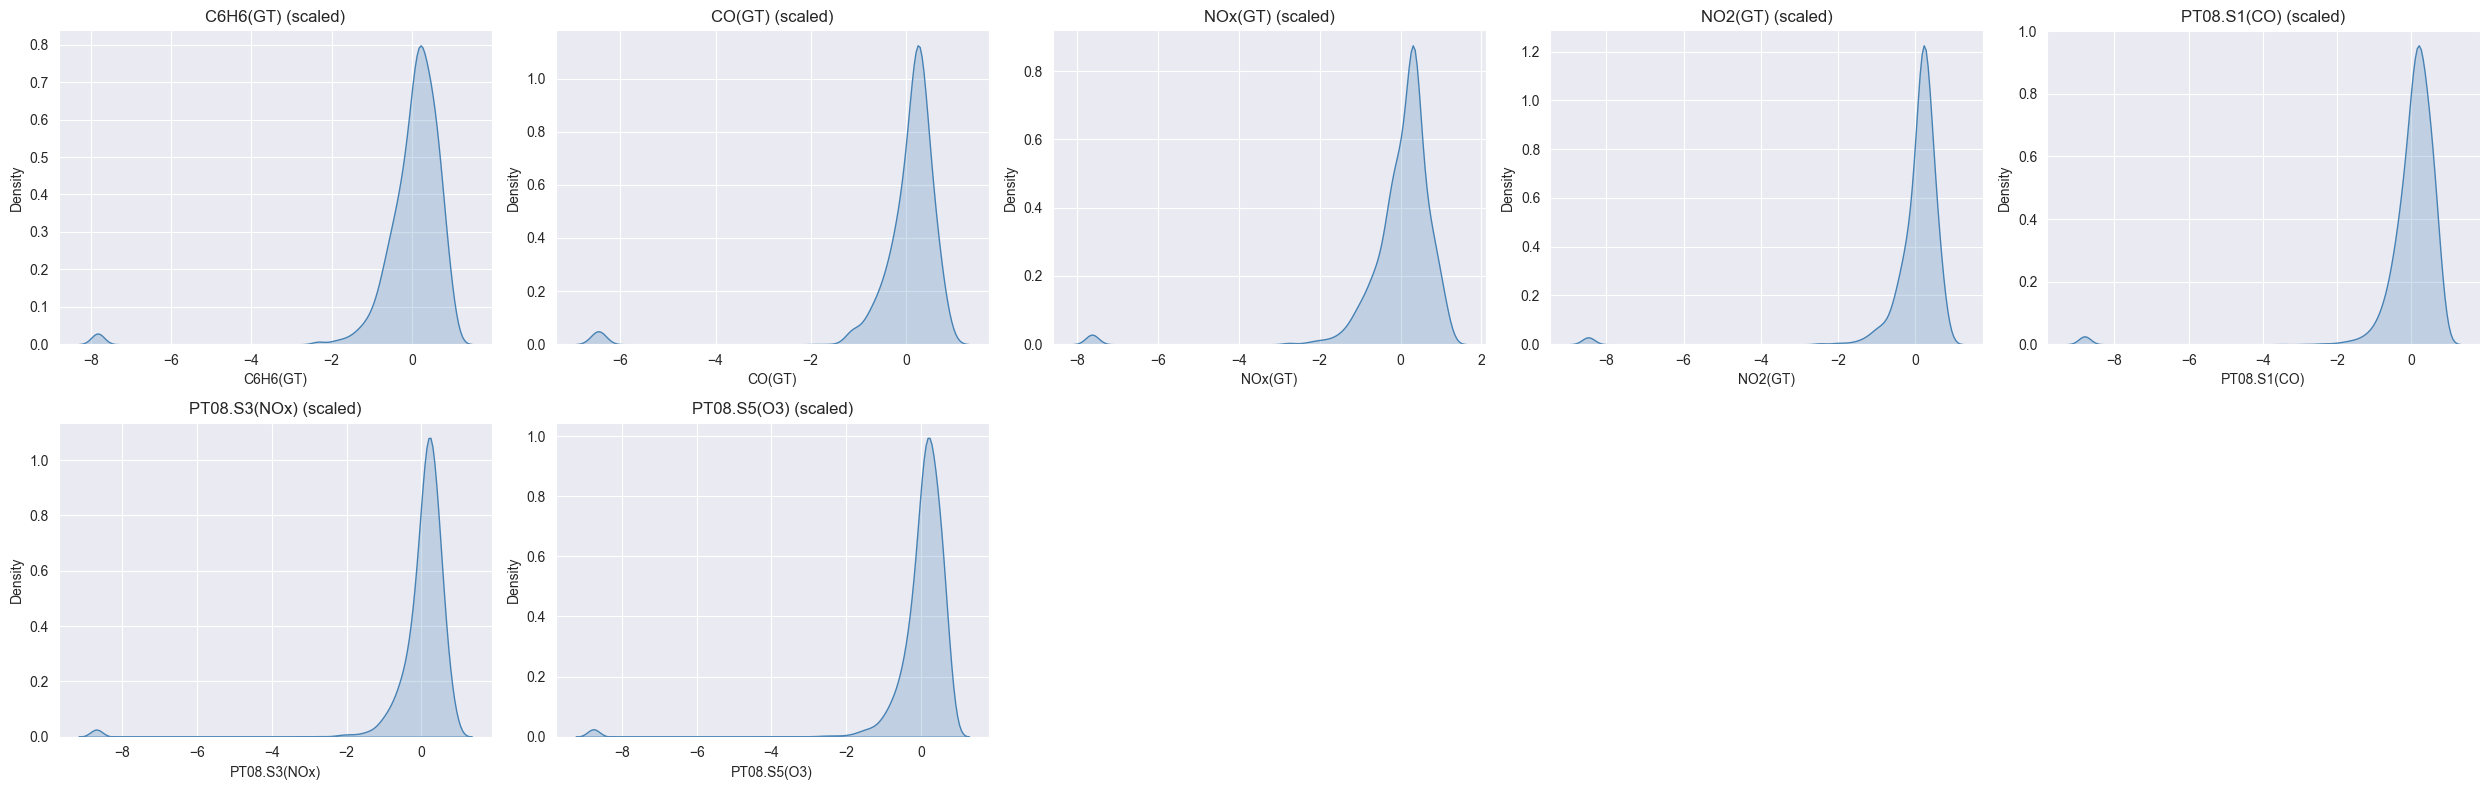

In [13]:
df_log = scale_standard(df_log, tran_cols)
plot_scaled(df_log, tran_cols)

### Conclusion on Distribution Transformations

While all tested transformations (QuantileTransformer, PowerTransformer, Log-transform) effectively reduce skewness, they also introduce significant distortions in the original distribution shapes.

- **QuantileTransformer** imposes an artificial normal distribution, eliminating the original modality and tail structure of features. While this can help certain algorithms, it comes at the cost of interpretability and local distribution features.

- **PowerTransformer (Yeo-Johnson)** is less aggressive, yet it still smooths peaks and stretches tails, altering the natural variability and visual shape of the data.

- **Log-transform** with shift towards positivity handles right-skewed features more naturally, but still compresses larger values and shifts focus toward the lower range.

**Summary**:
If preserving the original shape of the data is important, then:

- Either keep the data as is (especially if not heavily skewed),
- Or apply milder transformations (e.g. log-transform selectively, only for highly skewed features).

Maybe, we could use stronger transformations only if the modeling approach explicitly benefits from normality.


## Save dataframe for the next step - Machine Learning

In [14]:
save_dataframe(df_scl, path='data/processed', filename='AirQualityUCI_capper_scaler.csv')
df_scl.head(5)

Dataset saved to: data/processed\AirQualityUCI_capper_scaler.csv


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
0,2004-03-10,18.00.00,0.384175,1.250363,0.273367,-0.393682,0.919240,0.030313,0.706328,0.642938,-0.541880,-0.020429,-0.672485,2004-03-10 18:00:00,18
1,2004-03-10,19.00.00,-0.081496,0.926020,-0.079162,-0.724869,1.404935,-0.446724,0.308849,-0.123442,-0.576473,-0.091008,-0.753946,2004-03-10 19:00:00,19
2,2004-03-10,20.00.00,0.073727,1.450693,-0.135567,-0.577675,1.264989,0.053029,0.296894,0.140648,-0.737911,0.279532,-0.691653,2004-03-10 20:00:00,20
3,2004-03-10,21.00.00,0.073727,1.326679,-0.107365,-0.362140,1.067418,0.234757,0.383563,0.474645,-0.841692,0.632427,-0.599600,2004-03-10 21:00:00,21
4,2004-03-10,22.00.00,-0.391944,0.830624,-0.488096,-0.577675,1.532533,0.098461,0.102638,0.233857,-0.818630,0.608901,-0.594303,2004-03-10 22:00:00,22
